# Homework 6

##### Data: HW6_data.csv

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, October 20th, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

**Michelle (Chia Chi) Ho, Jiejun Lu, Jiawen Tong**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import pandas as pd
%matplotlib inline

from scipy.stats import norm, uniform
import seaborn as sns
import time

## Question 1: Can I sample from F-R-I-E-N-D-S without rejection?  It's Important!

**Coding required**


*Haven't we made it obvious?* In HW 5 we were introduced to $X$ a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

*Haven't we made it clear?*  We were also introduced to $h$ the following function of $X$:

$$h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}$$


*Want us to spell it out for you?* Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:

**1.1.** Rejection sampling with a normal proposal distribution and appropriately chosen parameters (aka rejection on steroids)

**1.2.** Importance sampling with a uniform proposal distribution

**1.3.** Importance sampling with a normal proposal distribution and appropriately chosen parameters

--

**1.4.** So far (in HWs 5 and 6) we've computed estimates of $\mathbb{E}[h(X)]$ for the following list of methods:

* Inverse Transform Sampling
* Rejection Sampling with a uniform proposal distribution (rejection sampling in a rectangular box with uniform probability of sampling any x)
* Rejection sampling with a normal proposal distribution and appropriately chosen parameters (aka rejection on steroids)
* Importance sampling with a uniform proposal distribution
* Importance sampling with a normal proposal distribution and appropriately chosen parameters.

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ you calculated in this list. Which sampling methods and associated proposal distributions would you expect based on discussions from lecture to have resulted in lower variances? How well do your results align with these expectations?

**Gratuitous Titular Reference**:  Annemarie and Marshmello's [F-R-I-E-N-D-S](https://www.youtube.com/watch?v=CY8E6N5Nzec) samples from French Hip Hop artist Rapsa's [42 Mesures à ta Sa(i)nté](https://www.youtube.com/watch?v=JivaoPSAgLI) a homage to his hometown of Saint-Étienne.

In [4]:
def f(x):
    if x < 1.:
        return 0
    elif x >=1 and x <= 3:
        return 1/12 * (x - 1)
    elif x > 3 and x <= 5:
        return -1/12 * (x - 5)
    elif x > 5 and x <= 7:
        return 1/6 * (x - 5)
    elif x > 7 and x <= 9:
        return -1/6 * (x - 9)
    else:
        return 0
    
def h(x):
    return 1/(3*np.sqrt(2)*np.pi) * np.exp(-1/18 * (x-5)**2)

def get_M(f, g, prop_mu, prop_sigma, x_min, x_max):
    x_space = np.linspace(x_min, x_max, 1000)
    fbyg = [f(x)/g(x, prop_mu, prop_sigma) for x in x_space]
    M = fbyg[np.argmax(fbyg)]
    return M

def inv_cdf(y):
    if y < 0 or y > 1: raise Exception('y must be within (0, 1).')
    elif y>= 0 and y <= 1/6:
        return np.sqrt(24*y) + 1
    elif y > 1/6 and y <= 1/3:
        return 5 - np.sqrt(8 - 24*y)
    elif y > 1/3 and y <= 2/3:
        return 5 + np.sqrt(12*y - 4)
    elif y > 2/3 and y < 1:
        return 9 - np.sqrt(12 - 12*y)

def inverse_transform_sampling(inv_cdf, h, n):    
    sample_y = np.random.uniform(0, 1, n)
    sample_x = [inv_cdf(y) for y in sample_y]
    mean = np.mean([h(x) for x in sample_x])
    std = np.std([h(x) for x in sample_x])
    
    return sample_x, mean, std

def uniform_rejection_sampling(n, M, f, g, h, prop_loc, prop_scale, x_min, x_max):
    
    samples = []
    while (len(samples) < n):
        xproposal = np.random.uniform(x_min, x_max)
        y = np.random.uniform(0, 1)
        
        if y <= f(xproposal)/(M * g(xproposal, prop_loc, prop_scale)):
            samples.append(xproposal)
    mean = np.mean([h(x) for x in samples])
    std = np.std([h(x) for x in samples])
    return samples, mean, std

def normal_rejection_sampling(n, M, f, g, h, prop_loc, prop_scale, x_min, x_max):
    samples = []
    accepted = 0
    outside = 0
    count = 0
    
    while (accepted < n):
        while 1:
            xproposal = norm.rvs(loc = prop_loc, scale = prop_scale)
            if xproposal > x_min and xproposal < x_max:
                break
            outside += 1
        y = np.random.uniform(0, 1)
        
        # accept/reject comparison
        if y < f(xproposal)/ (M*g(xproposal, prop_loc, prop_scale)):
            samples.append(xproposal)
            accepted += 1
        count += 1


    mean = np.mean([h(x) for x in samples])
    std = np.std([h(x) for x in samples])
    
    return np.array(samples), mean, std


def uniform_importance_sampling(n, f, g, h, prop_loc, prop_scale, x_min, x_max):
    # sample n from uniform distribution
    unifsamps = []
    while (len(unifsamps) < n):
        xproposal = uniform.rvs(loc=prop_loc, scale=prop_scale, size=1)
        if xproposal > x_min and xproposal < x_max:
            unifsamps.append(xproposal)
    unifsamps = np.array(unifsamps)
    fbygfunc = lambda x, prop_loc, prop_scale: f(x)/g(x, prop_loc, prop_scale)
    fbygmean = np.mean([fbygfunc(x, prop_loc, prop_scale) for x in unifsamps])
    samples = [h(x)*fbygfunc(x, prop_loc, prop_scale)/fbygmean for x in unifsamps]
    mean = np.mean(samples)
    std = np.std(samples)

    return np.array(samples), mean, std

def normal_importance_sampling(n, f, g, h, prop_loc, prop_scale, x_min, x_max):
    # sample n from normal distribution
    nsamps = []
    while (len(nsamps) < n):
        xproposal = norm.rvs(loc=prop_loc, scale=prop_scale, size=1)
        if xproposal > x_min and xproposal < x_max:
            nsamps.append(xproposal)
    nsamps = np.array(nsamps)
    fbygfunc = lambda x, prop_loc, prop_scale: f(x)/g(x, prop_loc, prop_scale)
    fbygmean = np.mean([fbygfunc(x, prop_loc, prop_scale) for x in nsamps])
    samples = [h(x)*fbygfunc(x, prop_loc, prop_scale)/fbygmean for x in nsamps]
    mean = np.mean(samples)
    std = np.std(samples)
    return samples, mean, std


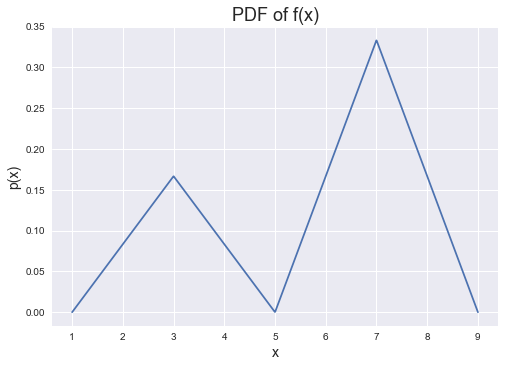

In [5]:
## Visualize the pdf of f
x_space = np.linspace(1, 9, 1000)
plt.plot(x_space, [f(x) for x in x_space]);
plt.title('PDF of f(x)', fontsize=18);
plt.xlabel('x', fontsize=14);
plt.ylabel('p(x)', fontsize=14);

In [6]:
## define variables for the problem
n = 10000

# domain of x
x_min = 1
x_max = 9

# proposal distributions
norm_prop = lambda x, prop_loc, prop_scale: norm.pdf(x, loc=prop_loc, scale=prop_scale)
uniform_prop = lambda x, prop_loc, prop_scale: uniform.pdf(x, loc=prop_loc, scale=prop_scale)

# proposal distribution params
norm_mu = 5
norm_sigma = 2
unif_loc = 1
unif_scale = 10
norm_M = get_M(f, norm_prop, norm_mu, norm_sigma, x_min, x_max)
unif_M = get_M(f, uniform_prop, unif_loc, unif_scale, x_min, x_max)

### Answer 1.1

Based on the pdf, an appropriate normal proposal distribution should have a center = 5 and a spread of at least 2. Below, we used a center of 5 and a spread of 2.

---

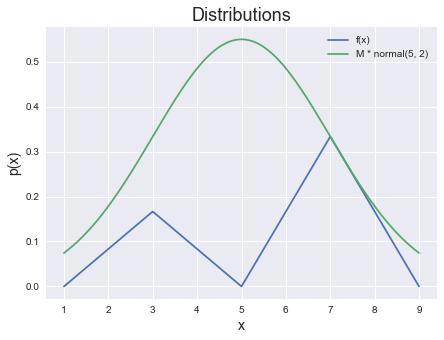

In [7]:
# check M is appropriate
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(x_space, [f(x) for x in x_space], label='f(x)');
ax.plot(x_space, [norm_M*norm_prop(x, norm_mu, norm_sigma) for x in x_space], label='M * normal(5, 2)');
ax.set_title('Distributions', fontsize=18);
ax.set_xlabel('x', fontsize=14);
ax.set_ylabel('p(x)', fontsize=14);
plt.legend();

In [8]:
# sample using normal rejection sampling
rej_samples, rej_mean, rej_std = normal_rejection_sampling(n, norm_M, f, norm_prop, h, norm_mu, norm_sigma, x_min, x_max)
rej_mean, rej_std

(0.05865744470168702, 0.01028045226362218)

### Answer 1.2

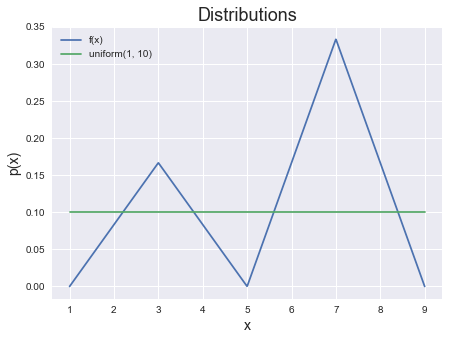

In [9]:
# visualize uniform distribution against f
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(x_space, [f(x) for x in x_space], label='f(x)');
ax.plot(x_space, [uniform_prop(x, unif_loc, unif_scale) for x in x_space], label='uniform(1, 10)');
ax.set_title('Distributions', fontsize=18);
ax.set_xlabel('x', fontsize=14);
ax.set_ylabel('p(x)', fontsize=14);
plt.legend();

In [10]:
# sample using uniform importance sampling
uis_samples, uis_mean, uis_std = uniform_importance_sampling(n, f, uniform_prop, h, unif_loc, unif_scale, x_min, x_max)
uis_mean, uis_std

(0.058872614352156814, 0.04259967382405799)

### Answer 1.3

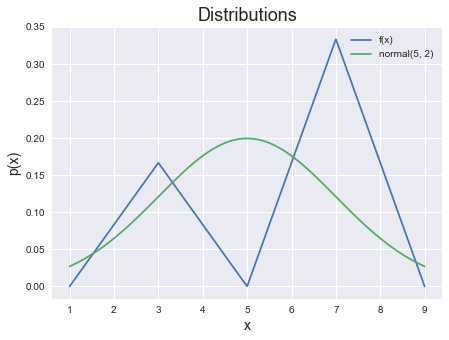

In [11]:
# visualize normal distribution against f
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(x_space, [f(x) for x in x_space], label='f(x)');
ax.plot(x_space, [norm_prop(x, norm_mu, norm_sigma) for x in x_space], label='normal(5, 2)');
ax.set_title('Distributions', fontsize=18);
ax.set_xlabel('x', fontsize=14);
ax.set_ylabel('p(x)', fontsize=14);
plt.legend();

In [12]:
# sample using normal importance sampling
nis_samples, nis_mean, nis_std = normal_importance_sampling(n, f, norm_prop, h, norm_mu, norm_sigma, x_min, x_max)
nis_mean, nis_std

(0.05884248666108063, 0.043102015857758885)

### Answer 1.4

In [11]:
eval_inv = []
eval_urs = []
eval_nrs = []
eval_uis = []
eval_nis = []

N_samples = 1000
for k in range(N_samples):
    print("k = {}".format(k), end='\r')
    inv_samples, inv_mean, inv_std = inverse_transform_sampling(inv_cdf, h, n)
    urs_samples, urs_mean, urs_std = uniform_rejection_sampling(n, unif_M, f, uniform_prop, h, unif_loc, unif_scale, x_min, x_max)
    nrs_samples, nrs_mean, nrs_std = normal_rejection_sampling(n, norm_M, f, norm_prop, h, norm_mu, norm_sigma, x_min, x_max)
    uis_samples, uis_mean, uis_std = uniform_importance_sampling(n, f, uniform_prop, h, unif_loc, unif_scale, x_min, x_max)
    nis_samples, nis_mean, nis_std = normal_importance_sampling(n, f, norm_prop, h, norm_mu, norm_sigma, x_min, x_max)
    
    # append expectations
    eval_inv.append(inv_mean)
    eval_urs.append(urs_mean)
    eval_nrs.append(nrs_mean)
    eval_uis.append(uis_mean)
    eval_nis.append(nis_std)


In [13]:
print("Variance of estimate of  E[h(X)] using: ")
print("Inverse transform sampling:   {}".format(np.std(np.array(eval_inv))))
print("Uniform rejection sampling:   {}".format(np.std(np.array(eval_urs))))
print("Normal rejection sampling:   {}".format(np.std(np.array(eval_nrs))))
print("Uniform importance sampling:   {}".format(np.std(np.array(eval_uis))))
print("Normal importance sampling:   {}".format(np.std(np.array(eval_nis))))

Variance of estimate of  E[h(X)] using: 
Inverse transform sampling:   0.00010050224705737027
Uniform rejection sampling:   0.00010371906098728104
Normal rejection sampling:   0.00010010626553497082
Uniform importance sampling:   9.907184098496526e-05
Normal importance sampling:   0.0003050081543043357


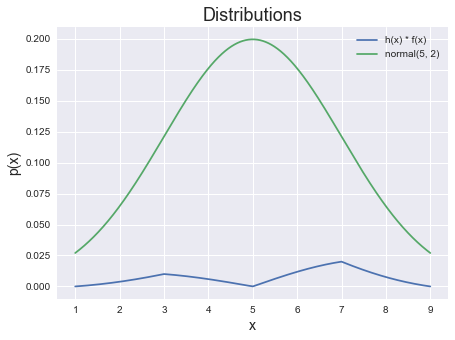

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(x_space, [h(x) * f(x) for x in x_space], label='h(x) * f(x)');
ax.plot(x_space, [norm_prop(x, norm_mu, norm_sigma) for x in x_space], label='normal(5, 2)');
ax.set_title('Distributions', fontsize=18);
ax.set_xlabel('x', fontsize=14);
ax.set_ylabel('p(x)', fontsize=14);
plt.legend();

### Answer 1.4
Importance sampling with a normal proposal distribution $\mathcal{N}(5, 2)$ resulted in the largest variance while the other methods show comparable variances. This is expected because the shape of $\mathcal{N}(5, 2)$ is very different from $f_X \cdot h$ --- the peak of $\mathcal{N}(5, 2)$ at $x=5$ corresponds to a minimum of $f_X \cdot h$ in between its bimodal peaks. In addition, the shape of the proposal distribution affects importance sampling but not rejection sampling. In rejection sampling, the shape of the proposal distribution affects the sampling efficiency but not on the variance of estimates. 

---

<div class="answer-separator">
------------------------
</div>

## Question 2: Mr. Poe Writes of Gradient Descent Into the Maelström`

Suppose you are building a pricing model for laying down telecom cables over a geographical region. You construct a pricing model that takes as input a pair of coordinates, $(x_1, x_2)$ and based upon two parameters $\lambda_1, \lambda_2$ predicts the loss in revenue corresponding to laying the cables at the inputed location.  Your pricing model is described by the following equation:

$$
\mathcal{L}(x_1, x_2\ \vert\ \lambda_1, \lambda_2) = 0.000045\lambda_2^2 x_2 - 0.000098\lambda_1^2 x_1 + 0.003926\lambda_1 x_1\exp\left\{\left(x_2^2 - x_1^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$

We've provided you some data contained in the file `HW6_data.csv`. This data represents a set of coordinates configured on the curve $x_2^2 - x_1^2 = -0.1$. Your general goal for this problem is to find the parameters $\lambda_1, \lambda_2$ that  minimize the net loss over the entire dataset.

**2.1.** Construct an appropriate visualization of the loss function for the given data.  Use that visualization to verify that for $\lambda_1 = 2.05384, \lambda_2 = 0$, the loss function $L$ is minimized.  Your visualization should make note of this optima.

**2.2.** Choose an appropriate learning rate  from [10, 1, 0.1, 0.01, 0.001, 0.0001] and use that learning rate to implement gradient descent.  Use your implementation to minimize $L$ for the given data.  Your implementation should be stored in a function named `gradient_descent`.  `gradient_descent` should take the following parameters (n represents the number of data points):

- `lambda_init` -- a numpy array with shape (2 , 1) containing the initial value for $\lambda_1$ and $\lambda_2$
- `X_data` -- an numpy array with shape (n, 2) containing the data coordinates used in your loss function
- `step_size` -- a float containing the step-size/learning rate used in your algorithm
- `scale` -- a float containing the factor by which you'll scale your step_size (or alternatively your loss) in the algorithm
- `max_iterations` -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
- `precision` -- a float containing the difference in loss between consecutive iterations below which you'll stop the algorithm
- `loss` -- a function (or lambda function) that takes in the following parameters and returns a float with the results of calculating the loss function for our data at $\lambda_1$ and $\lambda_2$
    - `lambdas` -- a numpy array with shape (2, 1) containing $\lambda_1$ and $\lambda_2$
    - `X_data` -- the same as the parameter `X_data` for `gradient_descent`
    
The return value for `gradient_descent` should be a dictionary with the following keys (n_itertions represents the total number of iterations):
- 'lambdas' -- the associated value is a numpy array with shape (2,1) containing the optimal $\lambda$'s found by the algorithm
- 'history' -- the associated value is a numpy array with shape (n_iterations,) containing a history of the calculated value of the loss function at each iteration


**2.3** For your implementation in 2.2, create a plot of loss vs iteration.  Does your descent algorithm comverge to the right values of $\lambda$?  At what point does your implementation converge?

**2.4.** Choose an appropriate learning rate  from [10, 1, 0.1, 0.01, 0.001, 0.0001] and use that learning rate to implement stochastic gradient descent.  Use your implementation to minimize $L$ for the given data.  Your implementation should a stored in a function named `stochastic_gradient_descent`.  `stochastic_gradient_descent` should take the following parameters (n represents the number of data points):

- `lambda_init` -- a numpy array with shape (2 , 1) containing the initial value for $\lambda_1$ and $\lambda_2$
- `X_data` -- an numpy array with shape (n, 2) containing the data coordinates for your loss function
- `step_size` -- a float containing the step-size/learning rate used in your algorithm
- `scale` -- a float containing the factor by which you'll scale your step_size (or alternatively your loss) in the algorithm
- `max_iterations` -- an integer containing a cap on the number of iterations for which you'll let your algorithm run
- `precision` -- a float containing the difference in loss between consecutive iterations below which you'll stop the algorithm
- `loss` -- a function (or lambda function) that takes in the following parameters and returns a float with the results of calculating the loss function for our data at $\lambda_1$ and $\lambda_2$
    - `lambdas` -- a numpy array with shape (2, 1) containing $\lambda_1$ and $\lambda_2$
    - `X_data` -- the same as the parameter `X_data` for `stochastic_gradient_descent`
    
The return value for `stochastic_gradient_descent` should be a dictionary with the following keys (n_itertions represents the total number of iterations):
- 'lambdas' -- the associated value is a numpy array with shape (2,1) containing the optimal $\lambda$'s found by the algorithm
- 'history' -- the associated value is a numpy array with shape (n_iterations,) containing a history of the calculated value of the loss function at each iteration


**2.5** For your implementation in 2.4, create a plot of loss vs iteration.  Does your descent algorithm comverge to the right values of $\lambda$?  At what point does your implementation converge?

**2.6** Compare the average time it takes to update the parameter estimation in each iteration of the two implementations. Which method is faster? Briefly explain why this result should be expected.

**2.7** Compare the number of iterations it takes for each algorithm to obtain an estimate accurate to `1e-3`.  You may wish to set a cap for maximum number of iterations.  Which method converges to the optimal point in fewer iterations?  Briefly explain why this result should be expected.

**2.8** Compare the performance of stochastic gradient descent on our loss function and dataset for the following learning rates: [10, 1, 0.1, 0.01, 0.001, 0.0001]. Based on your observations, briefly describe the effect of the choice of learning rate on the performance of the algorithm.

**2.9** Using your implementation of gradient descent and stochastic gradient descent, document the behavior of your two algorithms for the following starting points, and for a number of stepsizes of your choice:

- $(\lambda_1, \lambda_2) = (-2.47865, 0)$
- $(\lambda_1, \lambda_2) = (-3, 0)$
- $(\lambda_1, \lambda_2) = (-5, 0)$
- $(\lambda_1, \lambda_2) = (-10, 0)$

Construct a mathematical analysis of the loss function $\mathcal{L}$ to explain results of your descent algorithms at different starting points.

**Gratuitous Titular Reference**:  The renowned American auteur Edgar Allen Poe penned ["A Descent into the Maelström"](https://en.wikipedia.org/wiki/A_Descent_into_the_Maelstr%C3%B6m), a macabre tale of a seemingly elderly man's surviving a previous horrendous encounter with a massive hurricane, a shipwreck and a sea vortex, in 1841.

### Answer 2.1

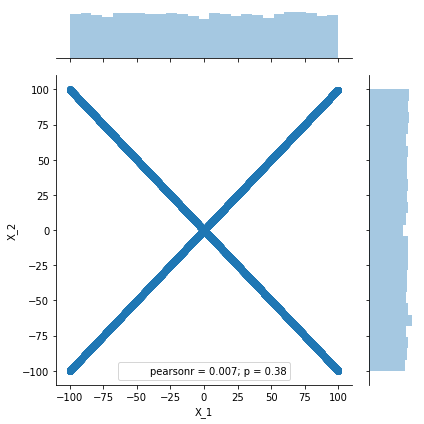

In [21]:
# 2.1
df = pd.read_csv('HW6_data.csv')

# simple visualization
sns.jointplot(df['X_1'], df['X_2'])
plt.tight_layout()

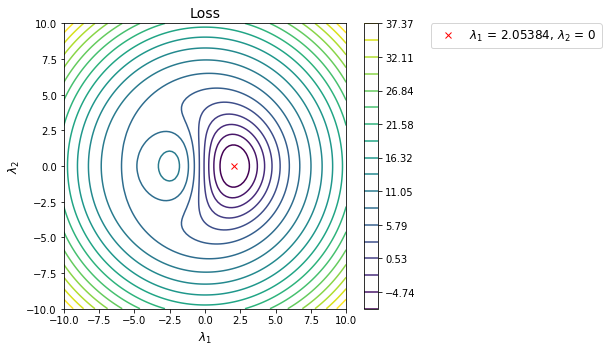

In [22]:
# function of L
def get_loss(x1, x2, lam1, lam2):
    a = 0.000045 * lam2**2 * x2.sum()
    b = (-0.000098) * lam1**2 * x1.sum()
    c = 0.003926 * lam1 * x1.sum() * np.exp(-0.1 * (lam1**2 + lam2**2))
    return a + b + c

# L's global minimum at (lam1_, lam2_)
lam1_ = 2.05384
lam2_ = 0

# lambdas' domain
lam1_lin = np.linspace(-10, 10, 100)
lam2_lin = np.linspace(-10, 10, 100)
lam1_grid, lam2_grid = np.meshgrid(lam1_lin, lam2_lin)
loss_grid = get_loss(df['X_1'], df['X_2'], lam1_grid, lam2_grid)

# contour plot
plt.subplots(figsize=(6, 5))
plt.contour(lam1_grid, lam2_grid, loss_grid, levels=np.linspace(-10, 40, 20))
plt.plot(lam1_, lam2_, 'rx', label=r'$\lambda_1$ = {}, $\lambda_2$ = {}'.format(lam1_, lam2_))
plt.colorbar()
plt.title('Loss', fontsize=14)
plt.xlabel(r'$\lambda_1$', fontsize=12)
plt.ylabel(r'$\lambda_2$', fontsize=12)
plt.legend(bbox_to_anchor=(1.3, 1), loc=2, borderaxespad=0., fontsize=12)
plt.tight_layout()

### Answer 2.2 2.3

The gradients of $\mathcal{L}(\lambda_1, \lambda_2\ \vert\ x_1, x_2)$ to $\lambda_1$, $\lambda_2$ are:

$$\frac{\partial \mathcal{L}}{\partial \lambda_1} = -2 \cdot 0.000098 \cdot x_1 \lambda_1 + 0.003926 \cdot x_1 (1 + 2\lambda_1^2(x_2^2 - x_1^2)) \cdot \exp\left\{(x_2^2-x_1^2)(\lambda_1^2 + \lambda_2^2)\right\}
$$

$$\frac{\partial \mathcal{L}}{\partial \lambda_2} = 2 \cdot 0.000045 \cdot x_2 \lambda_2 + 2 \cdot 0.003926 \cdot x_1 \lambda_1 \lambda_2 \cdot (x_2^2 - x_1^2) \cdot \exp\left\{(x_2^2-x_1^2)(\lambda_1^2 + \lambda_2^2)\right\}
$$

where $x_2^2 - x_1^2 = -0.1$

In [23]:
# 2.2, 2.3
def grad_lambda(lam1, lam2, X_data):
    d1_a = -2*0.000098*X_data[:, 0].sum()*lam1
    d1_b = 0.003926*X_data[:, 0].sum() * np.exp(-0.1*(lam1**2+lam2**2)) * (1-0.2*lam1**2)
    d_lam1 = d1_a + d1_b
    
    d2_a = 2*0.000045*X_data[:, 1].sum()*lam2
    d2_b = -0.2*0.003926*X_data[:, 0].sum()*lam1*lam2 * np.exp(-0.1*(lam1**2+lam2**2))
    d_lam2 = d2_a + d2_b
    
    return d_lam1, d_lam2

def gradient_descent(lambda_init, X_data, step_size, scale, max_iterations, precision, loss):
    ret_dict = {}
    ret_dict['history'] = []
    
    # initialization
    d_loss = precision + 999
    iters = 0
    lam1_cur, lam2_cur = lambda_init[0, 0], lambda_init[1, 0]
    loss_value = loss(X_data[:, 0], X_data[:, 1], lam1_cur, lam2_cur)
    lam_precision = np.linalg.norm(np.array([lam1_cur, lam2_cur]) - np.array([lam1_, lam2_]))
    
    time_update_param = []
    while (d_loss >= precision or d_loss < 0) and lam_precision >= precision and iters < max_iterations:
        # update lambdas
        t0 = time.time()
        d_lam1, d_lam2 = grad_lambda(lam1_cur, lam2_cur, X_data)
        lam1_cur -= step_size * scale * d_lam1
        lam2_cur -= step_size * scale * d_lam2
        time_update_param.append(time.time() - t0) # time to update params per iteration
        
        # update loss
        new_loss_value = loss(X_data[:, 0], X_data[:, 1], lam1_cur, lam2_cur)
        d_loss = loss_value - new_loss_value
        loss_value = new_loss_value
        ret_dict['history'].append(loss_value)
        
        # update ||lambda_current - lambda_argmin||^2
        lam_precision = np.linalg.norm(np.array([lam1_cur, lam2_cur]) - np.array([lam1_, lam2_]))
        
        iters += 1
    
    print('total iterations = {}'.format(iters))
    print('avg time per iteration to update lambdas = {}'.format(np.mean(time_update_param)))
    ret_dict['lambdas'] = np.array([[lam1_cur], [lam2_cur]])
    
    return ret_dict

=== Gradient Descent ===
total iterations = 12861
avg time per iteration to update lambdas = 5.7758175282129446e-05
lambda1 = 2.0535937069505117, lambda2 = 0.03913546552034066


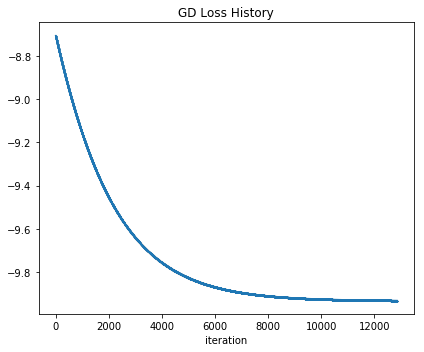

In [24]:
print('=== Gradient Descent ===')

GD_dict = gradient_descent(lambda_init=np.array([[2], [1]]), X_data=df.values, step_size=1e-4, scale=1, 
                           max_iterations=100000, precision=1e-6, loss=get_loss)

print('lambda1 = {}, lambda2 = {}'.format(GD_dict['lambdas'][0, 0], GD_dict['lambdas'][1, 0]))
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(GD_dict['history'], '.-', ms=1)
ax.set_title('GD Loss History')
ax.set_xlabel('iteration')
plt.tight_layout()

### Answer 2.3

Using `gradient_descent()`, $\lambda$'s converged to the true minumum (2.05384, 0) after 12861 iterations with the following hyper parameters:

- `inits = (2, 1)`, 

- `learning rate = step_size * scale = 0.0001`

- `max_iterations = 100000`

- `precision = 1e-6`

---

In [25]:
# 2.4, 2.5
def stochastic_grad_lambda(lam1, lam2, x1, x2):
    d1_a = -2*0.000098*x1*lam1
    d1_b = 0.003926*x1 * np.exp(-0.1*(lam1**2+lam2**2)) * (1-0.2*lam1**2)
    d_lam1 = d1_a + d1_b
    
    d2_a = 2*0.000045*x2*lam2
    d2_b = -0.2*0.003926*x1*lam1*lam2 * np.exp(-0.1*(lam1**2+lam2**2))
    d_lam2 = d2_a + d2_b
    
    return d_lam1, d_lam2

def stochastic_gradient_descent(lambda_init, X_data, step_size, scale, max_iterations, precision, loss):
    ret_dict = {}
    ret_dict['history'] = []
    
    # initialization
    d_loss = precision + 999
    iters = 0
    lam1_cur, lam2_cur = lambda_init[0, 0], lambda_init[1, 0]
    loss_value = loss(X_data[:, 0], X_data[:, 1], lam1_cur, lam2_cur)
    lam_precision = np.linalg.norm(np.array([lam1_cur, lam2_cur]) - np.array([lam1_, lam2_]))
    
    time_update_param = []
    while (d_loss >= precision or d_loss < 0) and lam_precision >= precision and iters < max_iterations:
        # randomly pick 1 data point
        idx = np.random.choice(len(X_data))
        xi = X_data[idx, :]
        # exit if d_loss already smaller than precision
        if (d_loss < precision and d_loss >= 0) or lam_precision < precision: 
            break

        # update lambdas
        t0 = time.time()
        d_lam1, d_lam2 = stochastic_grad_lambda(lam1_cur, lam2_cur, xi[0], xi[1])
        lam1_cur -= step_size * scale * d_lam1
        lam2_cur -= step_size * scale * d_lam2
        time_update_param.append(time.time() - t0) # time to update params per iteration

        # update loss
        new_loss_value = loss(X_data[:, 0], X_data[:, 1], lam1_cur, lam2_cur)
        d_loss = loss_value - new_loss_value
        loss_value = new_loss_value
        ret_dict['history'].append(loss_value)
        
        # update ||lambda_current - lambda_argmin||^2
        lam_precision = np.linalg.norm(np.array([lam1_cur, lam2_cur]) - np.array([lam1_, lam2_]))

        iters += 1 # 1 sample per iteration for SGD
    
    print('total iterations = {}'.format(iters))
    print('avg time per iteration to update lambdas = {}'.format(np.mean(time_update_param)))
    ret_dict['lambdas'] = np.array([[lam1_cur], [lam2_cur]])
    
    return ret_dict

=== Stochastic Gradient Descent ===
total iterations = 1319
avg time per iteration to update lambdas = 1.1624487355588692e-05
lambda1 = 2.0538442210994603, lambda2 = 0.008544119004746966


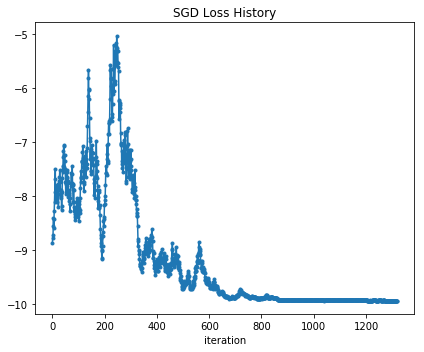

In [26]:
np.random.seed(1)
print('=== Stochastic Gradient Descent ===')
SGD_dict = stochastic_gradient_descent(lambda_init=np.array([[2], [1]]), X_data=df.values, 
                                       step_size=1, scale=1, max_iterations=100000, precision=1e-6, 
                                       loss=get_loss)

print('lambda1 = {}, lambda2 = {}'.format(SGD_dict['lambdas'][0, 0], SGD_dict['lambdas'][1, 0]))
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(SGD_dict['history'], '.-')
ax.set_title('SGD Loss History')
ax.set_xlabel('iteration')
plt.tight_layout()

### Answer 2.4, 2.5

Using `stochastic_gradient_descent()`, $\lambda$'s converged after 1319 iterations to the true minumum (2.05384, 0) with the following hyper parameters. The convergence would appear at different a time with a different random seed. The loss plot was much more stochastic than that from `gradient_descent()`.

- `inits = (2, 1)`, 

- `learning rate = step_size * scale = 1`

- `max_iterations = 100000`

- `precision = 1e-6`

---
### Answer 2.6

As printed above, the average time per iteration to update $\lambda$'s is 

- GD $\approx \text{5e-5}$, longer than 
- SGD $\approx \text{1e-5}$

This is expected since SGD only uses 1 data point in computing the gradient while GD uses the entire data set. We expect the slowdown of GD to be more obvious with a larger data set or with a more complicated gradient function. 

---

In [27]:
# 2.7
print('== Gradient Descent ==')
GD_dict = gradient_descent(lambda_init=np.array([[2], [1]]), X_data=df.values, step_size=0.01, scale=1, 
                 max_iterations=100000, precision=1e-3, loss=get_loss)
print('lambda1 = {}, lambda2 = {}'.format(GD_dict['lambdas'][0, 0], GD_dict['lambdas'][1, 0]))


np.random.seed(1)
print('\n== Stochastic Gradient Descent ==')
SGD_dict = stochastic_gradient_descent(lambda_init=np.array([[2], [1]]), X_data=df.values, step_size=1, scale=1, 
                            max_iterations=100000, precision=1e-3, loss=get_loss)
print('lambda1 = {}, lambda2 = {}'.format(SGD_dict['lambdas'][0, 0], SGD_dict['lambdas'][1, 0]))

== Gradient Descent ==
total iterations = 84
avg time per iteration to update lambdas = 6.779602595738002e-05
lambda1 = 2.052076727605542, lambda2 = 0.11914662274307884

== Stochastic Gradient Descent ==
total iterations = 664
avg time per iteration to update lambdas = 9.792755885296557e-06
lambda1 = 2.0505664222770363, lambda2 = 0.22616629419337644


### Answer 2.7

For both algorithms to achieve an accuracy of `1e-3`, it took 84 iterations for GD (`learning rate = 0.01`) and 664 iterations for SGD (`learning rate = 1`) to converge. (Note that the number of iterations for SGD to converge would be different for another random seed.) 

GD converges faster than SGD bacause GD updates the $\lambda$'s using all data points while SGD randomly pick 1 data point per iteration to locally and stochastically update the $\lambda$'s. Therefore SGD needs additional iterations to explore and find the correct gradient direction. But still, we argue that different starting points/random seed/objective function might have different results.

---

total iterations = 12
avg time per iteration to update lambdas = 2.0345052083333332e-05
2.0538608851940303 -0.0002682229749030833
total iterations = 795
avg time per iteration to update lambdas = 9.535843471311174e-06
2.05384117609258 0.011966748424695809
total iterations = 42351
avg time per iteration to update lambdas = 1.0101615781640616e-05
2.0534312495163487 0.07626989866492706
total iterations = 461354
avg time per iteration to update lambdas = 9.488267120950176e-06
2.0480768593738476 0.25995250959804506
total iterations = 730156
avg time per iteration to update lambdas = 9.382024932856814e-06
2.006167936437104 0.9192883944921111
total iterations = 30
avg time per iteration to update lambdas = 1.2572606404622396e-05
2.000002457394478 0.9999695315411791


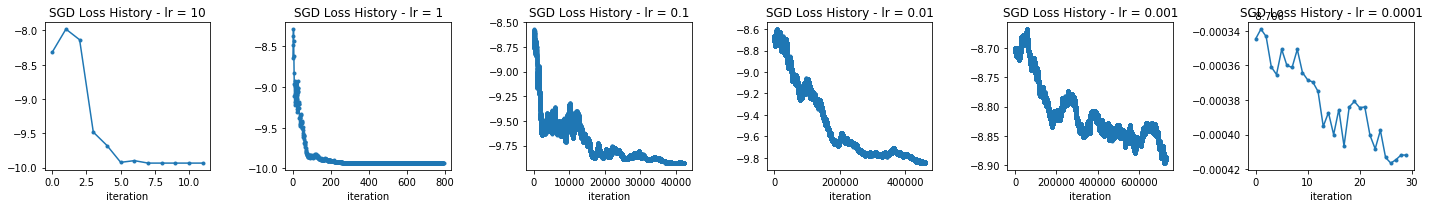

In [28]:
# 2.8
np.random.seed(3)
fig, axes = plt.subplots(1, 6, figsize=(20, 3))
final_losses = []
for _i, s in enumerate([10, 1, 0.1, 0.01, 0.001, 0.0001]):
    SGD_dict = stochastic_gradient_descent(lambda_init=np.array([[2], [1]]), X_data=df.values, 
                                       step_size=s, scale=1, max_iterations=1000000, precision=1e-6, 
                                       loss=get_loss)
    final_losses.append(SGD_dict['history'][-1])
    print(SGD_dict['lambdas'][0,0], SGD_dict['lambdas'][1,0])
    
    axes[_i].plot(SGD_dict['history'], '.-')
    axes[_i].set_title('SGD Loss History - lr = {}'.format(s))
    axes[_i].set_xlabel('iteration')

plt.tight_layout()

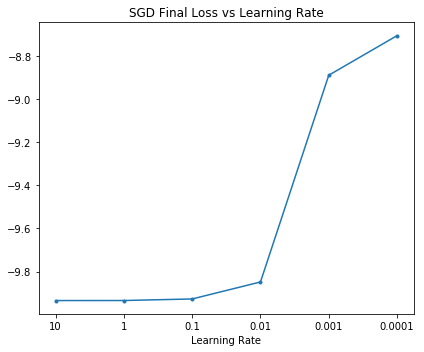

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(final_losses, '.-')
ax.set_xticklabels([0, '10', '1', '0.1', '0.01', '0.001', '0.0001'])
ax.set_xlabel('Learning Rate')
ax.set_title('SGD Final Loss vs Learning Rate')
plt.tight_layout()

### Answer 2.8

Based on the plot of SGD final losses at different learning rates, starting from (2, 1), SGD requires a learning rate $\in [0.1, 10]$ to converge within 1000000 iterations. For smaller learning rates, it would converge much slower.

---

In [30]:
# 2.9
lambda_inits = np.array([
    [-2.47865, 0],
    [-3, 0],
    [-5, 0],
    [-10, 0]
])

print('=== Gradient Descent ===')
for lam_init in lambda_inits:
    print('init =', lam_init)
    res = gradient_descent(lambda_init=lam_init.reshape(-1, 1), X_data=df.values, step_size=1e-3, scale=1, 
                     max_iterations=1000000, precision=1e-6, loss=get_loss)
    print('lambda_1 = {}, lambda_2 = {}'.format(res['lambdas'][0, 0], res['lambdas'][1, 0]))
    print('final loss = {}\n'.format(res['history'][-1]))

=== Gradient Descent ===
init = [-2.47865  0.     ]
total iterations = 1
avg time per iteration to update lambdas = 0.0004181861877441406
lambda_1 = -2.4786500127466624, lambda_2 = 0.0
final loss = 11.954580308599668

init = [-3.  0.]
total iterations = 3055
avg time per iteration to update lambdas = 9.171997856976748e-05
lambda_1 = -5.345013301292556, lambda_2 = 0.0
final loss = 8.161816538024409

init = [-5.  0.]
total iterations = 1723
avg time per iteration to update lambdas = 5.763226031426836e-05
lambda_1 = -5.3450147409257855, lambda_2 = 0.0
final loss = 8.161816492568821

init = [-10.   0.]
total iterations = 3634
avg time per iteration to update lambdas = 7.301683798555365e-05
lambda_1 = -5.381510611118554, lambda_2 = 0.0
final loss = 8.161817051579325



In [33]:
np.random.seed(0)
print('=== Stochastic Gradient Descent ===')
for lam_init in lambda_inits:
    res = stochastic_gradient_descent(lambda_init=lam_init.reshape(-1, 1), X_data=df.values, 
                                      step_size=1, scale=1, max_iterations=1000000, precision=1e-6, loss=get_loss)
    print('lambda_1 = {}, lambda_2 = {}'.format(res['lambdas'][0, 0], res['lambdas'][1, 0]))
    print('final loss = {}\n'.format(res['history'][-1]))

=== Stochastic Gradient Descent ===
total iterations = 2
avg time per iteration to update lambdas = 2.288818359375e-05
lambda_1 = -2.4786496468852324, lambda_2 = 0.0
final loss = 11.95458030860412

total iterations = 730
avg time per iteration to update lambdas = 9.688285932148973e-06
lambda_1 = -2.4852798593926964, lambda_2 = 0.0
final loss = 11.954505601472057

total iterations = 5292
avg time per iteration to update lambdas = 1.9134397499505445e-05
lambda_1 = -5.3481239972119505, lambda_2 = 0.0
final loss = 8.161726698260564

total iterations = 6959
avg time per iteration to update lambdas = 1.1019330546163522e-05
lambda_1 = -5.371961667642244, lambda_2 = 0.0
final loss = 8.161594352048002



In [34]:
def grad_2nd_lambda(lam1, lam2, X_data):
    d11 = -2*0.000098*X_data[:, 0].sum() - 0.2*0.003926*X_data[:, 0].sum()*lam1*np.exp(-0.1*(lam1**2+lam2**2))*(3-0.2*lam1**2)
    d12 = -0.2*0.003926*X_data[:, 0].sum() * lam2*(1-0.2*lam1**2) * np.exp(-0.1*(lam1**2+lam2**2)) 
    d21 = d12
    d22 = 2*0.000045*X_data[:, 1].sum() - 0.2*0.003926*X_data[:, 0].sum()*lam1* (1-0.2*lam2**2)*np.exp(-0.1*(lam1**2+lam2**2))
    return d11, d12, d21, d22

d1_1, d2_1 = grad_lambda(-2.479, 0, df.values)
d11, d12, d21, d22 = grad_2nd_lambda(-2.479, 0, df.values)
hessian_1 = d11 * d22 - d12 * d21
print('@(-2.479, 0)')
print('Gradient =', (d1_1, d2_1))
print('|Hessian| =', hessian_1)

d1_2, d2_2 = grad_lambda(-5.364, 0, df.values)
d11, d12, d21, d22 = grad_2nd_lambda(-5.364, 0, df.values)
hessian_2 = d11 * d22 - d12 * d21
print('\n@(-5.364, 0)')
print('Gradient =', (d1_2, d2_2))
print('|Hessian| =', hessian_2)

@(-2.479, 0)
Gradient = (0.0012029062973392124, 0.0)
|Hessian| = 5.936393633663378

@(-5.364, 0)
Gradient = (-0.0012989343815816845, 0.0)
|Hessian| = -0.14471057175158936


### Answer 2.9

$$
\begin{align}
\frac{\partial^2 \mathcal{L}}{\partial \lambda_1^2} &= -2 \cdot 0.000098 \cdot x_1 \\
&+ 6\cdot  0.003926 \cdot x_1 \cdot  \lambda_1 \cdot  (x_2^2-x_1^2) \cdot \exp\left\{(x_2^2-x_1^2)(\lambda_1^2 + \lambda_2^2)\right\} \\
&+  4\cdot  0.003926 \cdot x_1 \cdot  \lambda_1^3 \cdot  (x_2^2-x_1^2)^2 \cdot \exp\left\{(x_2^2-x_1^2)(\lambda_1^2 + \lambda_2^2)\right\} \\ \\
\frac{\partial^2 \mathcal{L}}{\partial \lambda_2^2} &= 2 \cdot 0.000045 \cdot x_2 \\
&+ 2 \cdot 0.003926 \cdot x_1 \lambda_1 \cdot (x_2^2 - x_1^2) \cdot \exp\left\{(x_2^2-x_1^2)(\lambda_1^2 + \lambda_2^2)\right\} \\
&+ 4 \cdot 0.003926 \cdot x_1 \lambda_1 \lambda_2^2 \cdot (x_2^2 - x_1^2)^2 \cdot \exp\left\{(x_2^2-x_1^2)(\lambda_1^2 + \lambda_2^2)\right\}
\end{align}
$$



Supported by the visualization in 2.1, the 1st gradient of $\mathcal{L(\lambda_1, \lambda_2)}$ at either (-2.479, 0) or (-5.364, 0) is 0, 

- (-2.479, 0) is a critical point and local extreme; 

- (-5.364, 0) is a critical point and saddle point (see plateau around (-5.36, 0))

Therefore, depending on the learning rate, both GD and SGD can get trapped at the 2 points; but by stochastically picking 1 data point to descent may help SGD to slip away and converge to the global minimum (2.05384, 0).


---

<div class="answer-separator">
------------------------
</div>